In [2]:
library(tidyverse)
library(magrittr)
library(MASS)
plotsize = function (x,y) options(repr.plot.width=x, repr.plot.height=y)
logit = function(p) log(p/1-p)
logistic = function(x) 1/(1+exp(-x))

In [3]:
rand_sigma <- function (n, ev = runif(n, 0, 10)) {
    Z <- matrix(ncol=n, rnorm(n^2))
    decomp <- qr(Z)
    Q <- qr.Q(decomp) 
    R <- qr.R(decomp)
    d <- diag(R)
    ph <- d / abs(d)
    O <- Q %*% diag(ph)
    Z <- t(O) %*% diag(ev) %*% O
    return(Z)
}

# The "Real World": $Y \sim \mathcal{N}(\beta_1x_1 + \beta_2x_2 + \dots \beta_{30}x_{30}, \sigma^2)$

In [4]:
n = 35
p = 30
sigma = diag(p)
mu = runif(p,-10,10)
beta = c(5,rnorm(p-1,0,1))
gen_data = function() {
    X = mvrnorm(n, mu, sigma) 
#     Y = rbinom(n,1,logistic(X %*% matrix(beta)))
    Y = X %*% matrix(beta) + rnorm(n,0,1)
    X %>%
        data.frame %>%
        mutate(Y = Y)
}

# Use four possible models to get confidence intervals

#### 1. $Y \sim \mathcal N (\alpha + \beta_1 x_1 + \beta_2 x_2, \sigma^2)$
#### 2. $Y \sim \mathcal N (\alpha + \beta_1 x_1 + \beta_3 x_3, \sigma^2)$
#### 3. $Y \sim \mathcal N (\alpha + \beta_1 x_1 + \beta_4 x_4, \sigma^2)$
#### 4. $Y \sim \mathcal{N}(\beta_1x_1 + \beta_2x_2 + \dots \beta_{30}x_{30}, \sigma^2)$

In [5]:
lm1 = function(df) {
    lm(Y~X1+X2, data=df) 
}
lm2 = function(df) {
    lm(Y~X1+X3, data=df) 
}
lm3 = function(df) {
    lm(Y~X1+X4, data=df) 
}
lm4 = function(df) {
    lm(Y~., data=df)
}
models = list(lm1=lm1, lm2=lm2, lm3=lm3, lm4=lm4)

get_ci = function(fit) {
    fit %>% 
    confint %>% 
    data.frame %>% 
    rename("L" = !!names(.[1]), "U" = !!names(.[2])) %>%
    rownames_to_column %>%
    filter(rowname=="X1") %>%
    dplyr::select(L,U)
}

A function that takes many datasets, fits a model on each, and returns confidence intervals

In [6]:
get_ci_reps = function(samples, model_function) {
    samples %>% 
    map(~model_function(.)) %>%
    map(~get_ci(.)) %>%
    bind_rows %>%
    arrange(L) %>%
    mutate(rep = row_number()) %>%
    gather(bound, value, U, L)
}

 Generate 100 datasets from the "real world"

In [7]:
samples = 1:100 %>%
    map(~gen_data())

Confidence intervals for $\beta_1$ using each model on 100 datasets from the "real world"

In [10]:
cis = models %>%
    imap(~get_ci_reps(samples, .x)) %>%
    imap(~mutate(.x, model=.y)) %>%
    bind_rows %>%
    spread(bound, value) %>%
    mutate(in_ci = (L<beta[1]) & (beta[1]<U)) %>%
    gather(bound, value, U, L)

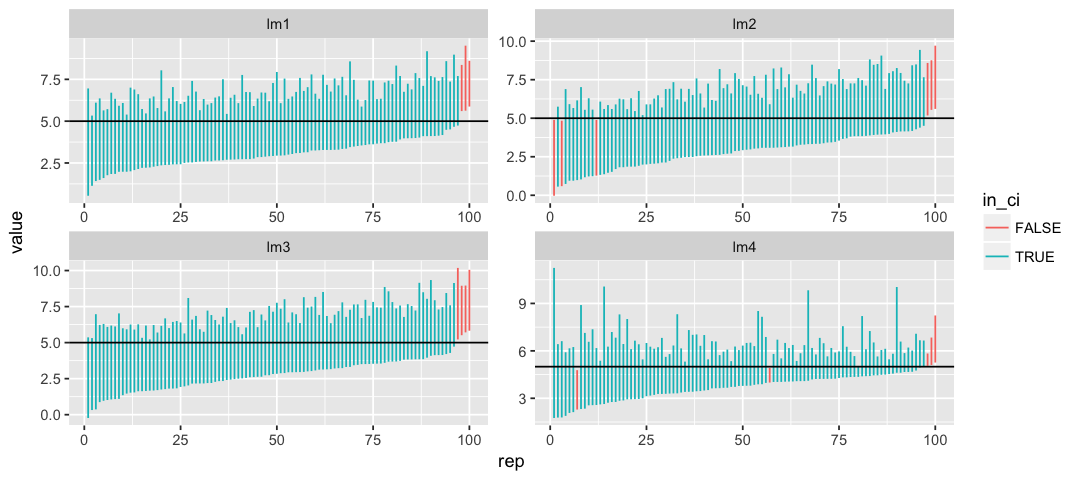

In [13]:
plotsize(9,4)
cis %>% 
ggplot(aes(x=rep, y=value)) +
    geom_line(aes(group=rep, color=in_ci)) + 
    geom_abline(slope=0, intercept=beta[1]) +
    facet_wrap(~model, scales="free")

Coverage of CIs

In [14]:
cis %>%
    spread(bound, value) %>%
    group_by(model) %>%
    summarize(coverage=mean(in_ci), coverage_sd=sd(in_ci)/sqrt(n())) %>% 
    data.frame

,model,coverage,coverage_sd
1,lm1,0.97,0.01714466
2,lm2,0.94,0.02386833
3,lm3,0.96,0.01969464
4,lm4,0.95,0.02190429


# Confidence Intervals After Model Selection

In [15]:
select_lm = function(df) {
    lm(Y~., data=df) %>% stepAIC(trace=F)
}

Do this procedure for each dataset. For each model returned, extract the confidence interval for $\beta_1$

In [16]:
cis_selection = get_ci_reps(samples, select_lm) %>%
    spread(bound, value) %>%
    mutate(in_ci = (L<beta[1]) & (beta[1]<U)) %>%
    gather(bound, value, U, L)

Coverage of CIs

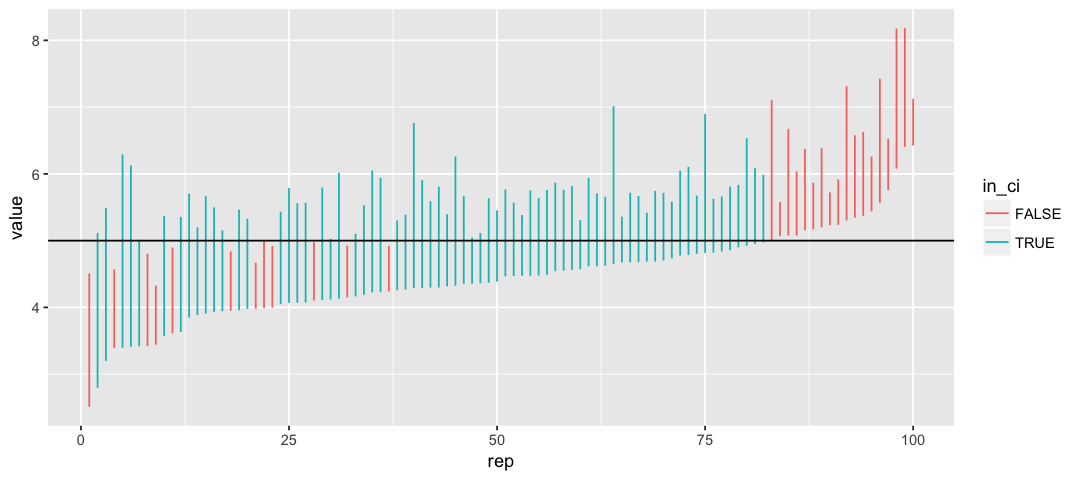

In [17]:
cis_selection %>%
ggplot(aes(x=rep, y=value)) +
    geom_line(aes(group=rep, color=in_ci)) + 
    geom_abline(slope=0, intercept=beta[1])

In [18]:
cis_selection %>%
    spread(bound, value) %>%
    mutate(in_ci = (L<beta[1]) & (beta[1]<U)) %>%
    summarize(coverage=mean(in_ci), coverage_sd=sd(in_ci)/sqrt(n())) %>% 
    data.frame

,coverage,coverage_sd
1,0.7,0.04605662
